In [1]:
import numpy as np
import torch
import torch_directml
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import os

Firstly we must set the device, my AMD RX 5700XT

In [2]:
device = torch_directml.device()

Then we have to set up the transformations for training and testing, in training we use them mainly for data augmentation. In both we normalize following ImageNet's mean and std. We also transform to tensor.

In [3]:
transform_train = transforms.Compose([
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandAugment(num_ops = 3, magnitude=9),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
  ])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])

We split the full dataset in training and testing

In [4]:
full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform_train, download=True)
test_ds = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform_test, download=True)

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


Doing a little check to see if the images and labels where loaded correctly 

In [16]:
def show_image(image):
    plt.figure(figsize=(1, 1))
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

Image colors can look strange because of the normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3395875..1.6611518].


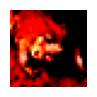

In [17]:
image, label = test_ds[5]
show_image(image)

Creating the loaders for the training and testing datasets

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_ds, batch_size = 128, shuffle = True, num_workers=os.cpu_count(), pin_memory=False)
test_loader = torch.utils.data.DataLoader(dataset = test_ds, batch_size = 128, shuffle = True, num_workers=os.cpu_count(), pin_memory=False)

Setting up the model to be used: ResNet50. We have to adapt the last layer to predict the 10 classes of CIFAR10. This architecture introduces residual blocks and shortcut connections to prevent the gradient descent issue. The gradient descent issue is when gradients are so small because of the backpropagation that it ends up slowing down training.

In [8]:
resnet50 = torchvision.models.resnet50().to(device) 
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 10).to(device) 

We will be using the CrossEntropyLoss criterion and the SGD optimizer with a pretty high learning rate (lr=0.1). The Cross Entropy Loss measures the difference between the predicted probability distribution and the real one to quantify how "wrong" the model is. Meanwhile SGD (Stochastic Gradient Descent) updates the parameters using gradients from each batch instead of the full dataset.

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
num_epochs = 100
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

num_batches_per_epoch = len(train_loader)
num_steps = num_batches_per_epoch * num_epochs # Calculating the number of steps to be able to set the number of iterations for the scheduler

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_steps) # Dynamic lr to prevent overfitting

Now we have to train the CNN with the training loop and to be on top of it we chose to check accuracy per epoch in both the training and testing datasets (to look for overfitting)

In [10]:
for epoch in range(num_epochs):
    resnet50.train(mode=True) # Training mode

    for inputs, targets in tqdm(train_loader): # Training loop
      inputs , targets = inputs.to(device) , targets.to(device)
      optimizer.zero_grad()
      outputs = resnet50(inputs)
      loss = criterion(outputs, targets.long())
      loss.backward()
      optimizer.step()
      lr_scheduler.step()

    correct_predictions = 0
    total_predictions = 0
    correct_predictions_training = 0
    total_predictions_training = 0

    resnet50.eval() # Inference mode

    with torch.no_grad(): # Checking accuracy on the testing dataset per epoch 
      for test_inputs, test_targets in tqdm(test_loader, desc='Calculating accuracy on testing dataset'):
        test_inputs, test_outputs = test_inputs.to(device), test_targets.to(device)
        test_outputs = resnet50(test_inputs)
        _, predicted = torch.max(test_outputs, 1)

        correct_predictions += (predicted.cpu() == test_targets.cpu()).sum().item()
        total_predictions += test_targets.size(0)
    with torch.no_grad(): # Checking accuracy on training dataset
      for train_inputs, train_targets in tqdm(train_loader, desc='Calculating accuracy on training dataset'):
        train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
        train_outputs = resnet50(train_inputs)
        _, predicted = torch.max(train_outputs, 1)

        correct_predictions_training += (predicted.to(device) == train_targets.to(device)).to(device).sum().item()
        total_predictions_training += train_targets.size(0)

    accuracy_training = (correct_predictions_training / total_predictions_training) * 100
    print(f"Accuracy in training: {accuracy_training}")
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Accuracy in testing: {accuracy}")

Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.95it/s]


Accuracy in training: 11.344999999999999
Accuracy in testing: 11.67


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.82it/s]


Accuracy in training: 15.5425
Accuracy in testing: 17.8


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.95it/s]


Accuracy in training: 20.845
Accuracy in testing: 23.69


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.93it/s]


Accuracy in training: 24.834999999999997
Accuracy in testing: 30.0


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.89it/s]


Accuracy in training: 29.709999999999997
Accuracy in testing: 36.46


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.97it/s]


Accuracy in training: 34.615
Accuracy in testing: 41.120000000000005


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.07it/s]


Accuracy in training: 37.6375
Accuracy in testing: 44.82


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.92it/s]


Accuracy in training: 39.9325
Accuracy in testing: 47.57


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.97it/s]


Accuracy in training: 42.3275
Accuracy in testing: 51.35999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.04it/s]


Accuracy in training: 43.9175
Accuracy in testing: 50.33


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 47.68
Accuracy in testing: 55.64


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s]


Accuracy in training: 44.2175
Accuracy in testing: 54.55


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.06it/s]


Accuracy in training: 49.877500000000005
Accuracy in testing: 59.209999999999994


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.10it/s]


Accuracy in training: 50.2725
Accuracy in testing: 60.089999999999996


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.06it/s]


Accuracy in training: 54.825
Accuracy in testing: 62.91


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.06it/s] 


Accuracy in training: 52.48500000000001
Accuracy in testing: 61.63999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.07it/s]


Accuracy in training: 58.052499999999995
Accuracy in testing: 65.89


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:33<00:00,  9.33it/s]


Accuracy in training: 57.96
Accuracy in testing: 65.39


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Accuracy in training: 59.91
Accuracy in testing: 67.54


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.31it/s]


Accuracy in training: 58.919999999999995
Accuracy in testing: 67.19000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.93it/s]


Accuracy in training: 58.684999999999995
Accuracy in testing: 66.29


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.17it/s]


Accuracy in training: 61.807500000000005
Accuracy in testing: 69.45


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


Accuracy in training: 59.07
Accuracy in testing: 66.19


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Accuracy in training: 62.580000000000005
Accuracy in testing: 69.23


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Accuracy in training: 63.895
Accuracy in testing: 70.97


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Accuracy in training: 62.6675
Accuracy in testing: 69.35


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.93it/s]


Accuracy in training: 60.315
Accuracy in testing: 68.60000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Accuracy in training: 65.41749999999999
Accuracy in testing: 71.04


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Accuracy in training: 63.3625
Accuracy in testing: 71.04


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.95it/s]


Accuracy in training: 64.63
Accuracy in testing: 71.28999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.34it/s]


Accuracy in training: 66.0575
Accuracy in testing: 73.53


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Accuracy in training: 64.51
Accuracy in testing: 71.31


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


Accuracy in training: 66.19500000000001
Accuracy in testing: 72.24000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.27it/s]


Accuracy in training: 68.33500000000001
Accuracy in testing: 74.47


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.31it/s]


Accuracy in training: 68.7075
Accuracy in testing: 73.56


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.23it/s]


Accuracy in training: 65.66499999999999
Accuracy in testing: 72.78999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


Accuracy in training: 69.315
Accuracy in testing: 74.53999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


Accuracy in training: 69.2525
Accuracy in testing: 74.75


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Accuracy in training: 68.0875
Accuracy in testing: 74.87


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.27it/s]


Accuracy in training: 67.175
Accuracy in testing: 74.00999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.99it/s]


Accuracy in training: 70.57
Accuracy in testing: 75.01


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s]


Accuracy in training: 69.505
Accuracy in testing: 74.66000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 70.84
Accuracy in testing: 75.49


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:32<00:00,  9.77it/s]


Accuracy in training: 71.35000000000001
Accuracy in testing: 76.69


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.89it/s]


Accuracy in training: 72.075
Accuracy in testing: 76.05


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.97it/s]


Accuracy in training: 72.8175
Accuracy in testing: 77.17


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.23it/s]


Accuracy in training: 71.93
Accuracy in testing: 76.6


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.20it/s] 


Accuracy in training: 72.845
Accuracy in testing: 77.13


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Accuracy in training: 72.88
Accuracy in testing: 77.41


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Accuracy in training: 73.30499999999999
Accuracy in testing: 78.39


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


Accuracy in training: 75.6875
Accuracy in testing: 78.77


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.27it/s]


Accuracy in training: 73.48
Accuracy in testing: 78.28


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s]


Accuracy in training: 72.595
Accuracy in testing: 76.84


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


Accuracy in training: 75.015
Accuracy in testing: 77.81


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Accuracy in training: 74.41250000000001
Accuracy in testing: 77.79


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Accuracy in training: 76.02499999999999
Accuracy in testing: 79.51


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Accuracy in training: 74.845
Accuracy in testing: 78.36999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.05it/s]


Accuracy in training: 77.67500000000001
Accuracy in testing: 79.78


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


Accuracy in training: 75.58749999999999
Accuracy in testing: 79.02


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.14it/s]


Accuracy in training: 76.9425
Accuracy in testing: 79.01


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.91it/s]


Accuracy in training: 77.1625
Accuracy in testing: 79.84


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.88it/s]


Accuracy in training: 78.955
Accuracy in testing: 81.35


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 78.5575
Accuracy in testing: 80.54


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 77.0075
Accuracy in testing: 79.64


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.02it/s]


Accuracy in training: 80.38250000000001
Accuracy in testing: 81.5


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.03it/s]


Accuracy in training: 81.08
Accuracy in testing: 82.22


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.04it/s]


Accuracy in training: 80.50500000000001
Accuracy in testing: 81.75


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 81.4025
Accuracy in testing: 82.45


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.05it/s] 


Accuracy in training: 81.0475
Accuracy in testing: 81.41000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.07it/s]


Accuracy in training: 82.9225
Accuracy in testing: 82.25


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 82.1425
Accuracy in testing: 82.09


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 83.1625
Accuracy in testing: 82.69999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 83.48
Accuracy in testing: 82.31


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 84.395
Accuracy in testing: 83.16


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.96it/s]


Accuracy in training: 84.9325
Accuracy in testing: 83.34


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.02it/s]


Accuracy in training: 84.83000000000001
Accuracy in testing: 83.03


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 86.7
Accuracy in testing: 83.87


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.03it/s]


Accuracy in training: 87.225
Accuracy in testing: 83.82


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.02it/s]


Accuracy in training: 86.855
Accuracy in testing: 84.31


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.03it/s]


Accuracy in training: 87.925
Accuracy in testing: 84.39999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.96it/s]


Accuracy in training: 88.53999999999999
Accuracy in testing: 84.61


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 88.725
Accuracy in testing: 84.99


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.03it/s]


Accuracy in training: 89.3825
Accuracy in testing: 84.95


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.99it/s]


Accuracy in training: 90.14750000000001
Accuracy in testing: 85.45


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Accuracy in training: 90.29
Accuracy in testing: 85.18


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s] 


Accuracy in training: 90.96
Accuracy in testing: 85.52


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


Accuracy in training: 91.19
Accuracy in testing: 85.39999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s]


Accuracy in training: 91.715
Accuracy in testing: 85.72


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s]


Accuracy in training: 92.3875
Accuracy in testing: 86.09


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.03it/s]


Accuracy in training: 92.415
Accuracy in testing: 86.33999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.05it/s]


Accuracy in training: 92.4475
Accuracy in testing: 86.11999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.93it/s] 


Accuracy in training: 92.9175
Accuracy in testing: 86.26


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.05it/s]


Accuracy in training: 93.0775
Accuracy in testing: 86.33999999999999


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.07it/s] 


Accuracy in training: 93.38250000000001
Accuracy in testing: 86.46000000000001


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.96it/s]


Accuracy in training: 93.4075
Accuracy in testing: 86.33


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00, 10.06it/s]


Accuracy in training: 93.5575
Accuracy in testing: 86.38


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.19it/s]


Accuracy in training: 93.9125
Accuracy in testing: 86.6


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


Accuracy in training: 93.5875
Accuracy in testing: 86.59


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s]


Accuracy in training: 93.8675
Accuracy in testing: 86.44


Calculating accuracy on training dataset: 100%|██████████| 313/313 [00:31<00:00,  9.97it/s]

Accuracy in training: 93.715
Accuracy in testing: 86.45


We ended up with a 86.45% accuracy on testing, which is great!

Lastly we test the model after training on a random image to see the final result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2215865..2.5781386].


Predicted class: 2
Class: 2


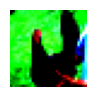

In [18]:
image, label = test_ds[25]
resnet50.eval()
res = resnet50(image.unsqueeze(0).to(device))
predicted_class = res.argmax(dim=1).item()
print(f'Predicted class: {predicted_class}')
print(f'Class: {label}')
show_image(image)